# *The Art of Natural Language Processing: Machine Learning for the Case Study*

### **Authors: Andrea Ferrario, Mara Nägelin**

**Date: February 2020** (updated September 2020)

Notebook to run the machine learning modeling in the Classical and Modern Approaches, as described in the tutorial `The Art of Natural Language Processing: Classical, Modern and Contemporary Approaches to Text Document Classification'.

# Table of contents
1. [Getting started with Python and Jupyter Notebook](#started)
2. [Import data](#import)
3. [Duplicated reviews](#duplicated)
4. [Data preprocessing](#preprocessing)
5. [POS-tagging](#POS)
6. [Pre-trained word embeddings](#emb)
7. [Data analytics](#analytics)  
    7.1. [A quick check of data structure](#check)  
    7.2. [Basic linguistic analysis of movie reviews](#basic)
8. [Machine learning](#ML)  
    8.1. [Adaptive boosting (ADA)](#ADA)  
    .......8.1.1. [Bag-of-words](#ADA_BOW)  
    .......8.1.2. [Bag-of-POS](#ADA_BOP)  
    .......8.1.3. [Embeddings](#ADA_E)  
    8.2. [Random forests (RF)](#RF)  
    .......8.2.1. [Bag-of-words](#RF_BOW)  
    .......8.2.2. [Bag-of-POS](#RF_BOP)  
    .......8.2.3. [Embeddings](#RF_E)  
    8.3. [Extreme gradient boosting (XGB)](#XGB)  
    .......8.3.1. [Bag-of-words](#XGB_BOW)  
    .......8.3.2. [Bag-of-POS](#XGB_BOP)  
    .......8.3.3. [Embeddings](#XGB_E)

# 1. Getting started with Python and Jupyter Notebook<a name="started"></a>

In this section, Jupyter Notebook and Python settings are initialized. For code in Python, the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) ("PEP = Python Enhancement Proposal") is enforced with minor variations to improve readibility.

In [75]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf') 

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotting
%matplotlib inline

# 2. Import data<a name="import"></a>

In [76]:
# we use the import function, as in Chapter 8 of Raschka's book (see the tutorial)
import pyprind
import pandas as pd
import os
basepath = './toymdb/' # insert basepath, where original data are stored

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

# 3. Duplicated reviews<a name="duplicated"></a>

In [77]:
# check for duplicates
duplicates = df[df.duplicated()]  #equivalent to keep = first. Duplicated rows, except the first entry, are marked as 'True'
print(len(duplicates))

0


In [78]:
# a check on the duplicated review
duplicates.review   

Series([], Name: review, dtype: object)

In [79]:
# remove duplicates: 
df = df.drop_duplicates()
df.shape

(500, 2)

In [80]:
# double check
df[df.duplicated(subset='review')]

,review,sentiment


# 4. Data preprocessing<a name="preprocessing"></a>

In [81]:
# an example of 'raw' review: we have all sort of HTML markup
df.loc[0, 'review'] # 0 to 499

'Great movie, great actors, great soundtrack! I loved it! Settings are perfect, dialogues, situations, storyline... all together mixed to give this masterpiece! Clooney and Turturro are magnificent and the Soggy Bottom Boys are simply charming and contagious with their music! :)'

In [82]:
# preprocessing by Raschka, Chpater 8 (see tutorial)
# we remove all markups, substitute non-alphanumeric characters (including 
# underscore) with whitespaces, and remove the nose from emoticons
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

In [83]:
# checking again the same review
df.loc[0, 'review']

'great movie great actors great soundtrack i loved it settings are perfect dialogues situations storyline all together mixed to give this masterpiece clooney and turturro are magnificent and the soggy bottom boys are simply charming and contagious with their music :)'

In [84]:
# save preprocessed data as csv 
# path = './toymdb/0_data_pre.csv'  # insert path
# df.to_csv(path, index=False, encoding='utf-8')

# 5. POS - tagging<a name="POS"></a>

In [85]:
# we apply POS-tagging on (deduplicated and) pre-processed data - let us import them
path = './toymdb/0_data_pre.csv' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(500, 2)

In [86]:
# we import the NLTK resources
import nltk
from nltk import pos_tag, word_tokenize

# introduction of POS tagger per NLTK token
def pos_tags(text):
    text_processed = word_tokenize(text)
    return "-".join( tag for (word, tag) in nltk.pos_tag(text_processed))

# applying POS tagger to data 
############################################
df['text_pos']=df.apply(lambda x: pos_tags(x['review']), axis=1)

In [87]:
# save POS-tagged data as csv 
# path = './toymdb/0_data_pos.csv' # insert path 
# df.to_csv(path, index=False, encoding='utf-8')

# 6. Pre-trained word embeddings<a name="emb"></a>

In [88]:
# we apply embeddings on de-duplicated and pre-processed data - let us import them
path = './toymdb/0_data_pre.csv' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(500, 2)

In [89]:
# import pre-trained word embedding model
import spacy
nlp = spacy.load('en_core_web_sm') # load the model first if necessary: python -m spacy download en_core_web_md

In [90]:
# we stack (like a numpy vertical stack) the 300 variables obtained from averaging the embedding of each df.review entry
# WARNING: this is computationally expensive. Alternatively try with the smaller model en_core_web_sm
import numpy as np
emb = np.vstack(df.review.apply(lambda x: nlp(x).vector))

In [91]:
# embeddings into a dataframe
emb = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, 96)]) )
print(emb.shape)
print(emb.columns.values)

(500, 96)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95']


In [92]:
# join embeddings with dataframe
df_embed = pd.concat([df, emb], axis=1)

In [93]:
# check the shape of the resulting dataframe
df_embed.shape

(500, 98)

In [94]:
# save word embedding data as csv 
# path = './toymdb/0_data_embed.csv' # insert path
# df_embed.to_csv(path, index=False, encoding='utf-8')

# 7. Data analytics<a name="analytics"></a>

We reproduce main data analytics results in Section 6.3 of the tutorial. We use the preprocessed and deduplicated data, for simplicity.

## 7.1. A quick check of data structure<a name="check"></a>

In [95]:
# importing data
import pandas as pd

path = './toymdb/0_data_pre.csv' # insert path for deduplicated and preprocessed data
df = pd.read_csv(path)

In [96]:
# imported data structure
df.shape

(500, 2)

In [97]:
# columns in data
df.columns

Index(['review', 'sentiment'], dtype='object')

In [98]:
# imported data: first 10 entries
df.head(10)

,review,sentiment
0,great movie great actors great soundtrack i lo...,1
1,the end of suburbia is an important documentar...,1
2,the intricate plot great visuals the world s g...,1
3,this is one of the few movies of this type i h...,1
4,luc besson s first work is also his first fora...,1
5,rarely does a film capture such intense drama ...,1
6,i kid you not yes who s that girl has the dist...,1
7,a boy who adores maurice richard of the montre...,1
8,the reason i think this movie is fabulous is t...,1
9,spoiler alert i worked as an extra on this lif...,1


In [99]:
# counts of rviews per sentiment value
df.sentiment.value_counts()

0    250
1    250
Name: sentiment, dtype: int64

## 7.2. Basic linguistic analysis of movie reviews<a name="basic"></a>

In [100]:
# show distribution of review lenghts 
# we strip leading and trailing whitespaces and tokenize by whitespace
df['word_count'] = df['review'].apply(lambda x: len(x.strip().split(" ")))
df[['review','sentiment', 'word_count']].head(10)

,review,sentiment,word_count
0,great movie great actors great soundtrack i lo...,1,41
1,the end of suburbia is an important documentar...,1,161
2,the intricate plot great visuals the world s g...,1,54
3,this is one of the few movies of this type i h...,1,117
4,luc besson s first work is also his first fora...,1,386
5,rarely does a film capture such intense drama ...,1,113
6,i kid you not yes who s that girl has the dist...,1,537
7,a boy who adores maurice richard of the montre...,1,57
8,the reason i think this movie is fabulous is t...,1,194
9,spoiler alert i worked as an extra on this lif...,1,239


In [101]:
# summary statistics of word counts
print(df['word_count'].describe())

count     500.000000
mean      228.182000
std       172.093432
min         6.000000
25%       126.000000
50%       170.500000
75%       274.000000
max      1032.000000
Name: word_count, dtype: float64


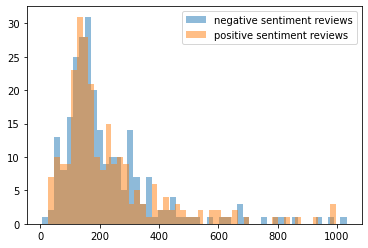

In [102]:
# show histograms of word counts divided per sentiment
from matplotlib import pyplot

x = df[df['sentiment']==0].word_count
y = df[df['sentiment']==1].word_count

pyplot.hist(x, bins=50, alpha=0.5, label='negative sentiment reviews')
pyplot.hist(y, bins=50, alpha=0.5, label='positive sentiment reviews')
pyplot.legend(loc='upper right')
pyplot.show()

In [103]:
# summary of distributions of word counts
print(x.describe())
print(y.describe())

count     250.000000
mean      225.304000
std       167.889365
min         6.000000
25%       128.000000
50%       173.000000
75%       273.250000
max      1032.000000
Name: word_count, dtype: float64
count    250.000000
mean     231.060000
std      176.487301
min       26.000000
25%      125.000000
50%      169.000000
75%      274.000000
max      995.000000
Name: word_count, dtype: float64


In [104]:
# some checks (e.g. word_counts=6 or 1550 or 2498 )
df[df['word_count']==6]

,review,sentiment,word_count
238,primary plot primary direction poor interpreta...,0,6


In [105]:
# average word length (again, we tokenize by whitespaces)
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['review'].apply(lambda x: avg_word(x.strip()))
df[['review','word_count', 'sentiment', 'avg_word']].head(10)

,review,word_count,sentiment,avg_word
0,great movie great actors great soundtrack i lo...,41,1,5.512195
1,the end of suburbia is an important documentar...,161,1,4.981366
2,the intricate plot great visuals the world s g...,54,1,4.240741
3,this is one of the few movies of this type i h...,117,1,4.333333
4,luc besson s first work is also his first fora...,386,1,4.430052
5,rarely does a film capture such intense drama ...,113,1,4.221239
6,i kid you not yes who s that girl has the dist...,537,1,4.292365
7,a boy who adores maurice richard of the montre...,57,1,4.964912
8,the reason i think this movie is fabulous is t...,194,1,4.067010
9,spoiler alert i worked as an extra on this lif...,239,1,4.213389


In [106]:
# distributions of word lengths conditional per sentiment
x = df[df['sentiment']==0].avg_word
y = df[df['sentiment']==1].avg_word
print(x.describe())
print()
print(y.describe())

count    250.000000
mean       4.292849
std        0.365534
min        3.500000
25%        4.079142
50%        4.295587
75%        4.509106
max        7.500000
Name: avg_word, dtype: float64

count    250.000000
mean       4.316774
std        0.340776
min        3.385093
25%        4.099108
50%        4.295241
75%        4.542389
max        5.512195
Name: avg_word, dtype: float64


In [113]:
# some checks (e.g. avg_word>=11)
df[df['avg_word']>=6]

,review,sentiment,word_count,avg_word,stopwords
238,primary plot primary direction poor interpreta...,0,6,7.5,0


In [114]:
# stop words statistics - stopword from NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['review'].apply(lambda x: len([x for x in x.strip().split() if x in stop]))
df[['review','word_count', 'sentiment', 'avg_word', 'stopwords']].head(10)

,review,word_count,sentiment,avg_word,stopwords
0,great movie great actors great soundtrack i lo...,41,1,5.512195,14
1,the end of suburbia is an important documentar...,161,1,4.981366,65
2,the intricate plot great visuals the world s g...,54,1,4.240741,23
3,this is one of the few movies of this type i h...,117,1,4.333333,53
4,luc besson s first work is also his first fora...,386,1,4.430052,182
5,rarely does a film capture such intense drama ...,113,1,4.221239,59
6,i kid you not yes who s that girl has the dist...,537,1,4.292365,262
7,a boy who adores maurice richard of the montre...,57,1,4.964912,25
8,the reason i think this movie is fabulous is t...,194,1,4.067010,121
9,spoiler alert i worked as an extra on this lif...,239,1,4.213389,114


In [115]:
# distributions of stop words conditional per sentiment
x = df[df['sentiment']==0].stopwords
y = df[df['sentiment']==1].stopwords
print(x.describe())
print()
print(y.describe())

count    250.00000
mean     110.61600
std       82.60588
min        0.00000
25%       62.00000
50%       85.00000
75%      136.00000
max      523.00000
Name: stopwords, dtype: float64

count    250.000000
mean     113.608000
std       86.026978
min        8.000000
25%       62.000000
50%       87.000000
75%      130.750000
max      491.000000
Name: stopwords, dtype: float64


In [116]:
# some checks (e.g. stopwords==0)
df[df['stopwords']==0]

,review,sentiment,word_count,avg_word,stopwords
238,primary plot primary direction poor interpreta...,0,6,7.5,0


# 8. Machine Learning<a name="ML"></a>

We replicate the machine learning pipelines from the tutorial, Section 6.4 (Classical and Modern Approaches).

**WARNING**: as mentioned in the tutorial, the following cross-validation routines are computationally intensive. We recommend to sub-sample data and/or use HPC infrastructure (specifying the parameter njobs in GridSearch() accordingly). Test runs can be launched on reduced hyperparameter grids, as well. 
Note that we ran all the machine learning routines presented in this section on the ETH High Performance Computing (HPC) infrastructure [Euler](https://scicomp.ethz.ch/wiki/Euler), by submitting all jobs to a virtual machine consisting of 32 cores with 3072 MB RAM per core (total RAM: 98.304 GB). Therefore, notebook cell outputs are not available for this section.

## 8.1. Adaptive boosting (ADA)<a name="ADA"></a>

We use the adaptive boosting (ADA) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings).

### 8.1.1. Bag-of-words<a name="ADA_BOW"></a>

In [119]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = './toymdb/0_data_pre.csv'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)     

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],           # choose (1, 2) to compute 2-grams
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                          
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]
              }

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)               # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

---------------------
---------------------
---------------------
---------------------
X_train shape check:  (500,)
X_test shape check:  (500,)
---------------------
---------------------
---------------------
---------------------


KeyboardInterrupt: 

### 8.1.2. Bag-of-POS<a name="ADA_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_pos.csv'  # insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).text_pos
y_train = df.head(39666).sentiment

X_test = df.tail(9916).text_pos
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.1.3. Embeddings<a name="ADA_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_embed.csv'  # insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)      # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 700, 900, 1000],
#              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='accuracy',
                           cv=cv)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

## 8.2. Random Forests (RF)<a name="RF"></a>

We use the random forests (RF) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings).

### 8.2.1. Bag-of-words<a name="RF_BOW"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_pre.csv'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],    # for 2-grams:(1, 2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)       # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.2.2. Bag-of-POS<a name="RF_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_pos.csv'  # insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).text_pos
y_train = df.head(39666).sentiment

X_test = df.tail(9916).text_pos
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)              # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.2.3. Embeddings<a name="RF_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = './toymdb/0_data_embed.csv'  # insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)     # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
             }

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
#              'clf__max_depth': [1, 5, 10, 20]}

pipe = Pipeline([('clf', RandomForestClassifier())
               ])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv)               # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

## 8.3. Extreme gradient boosting (XGB)<a name="XGB"></a>

We use the extreme gradient boosting (XGB) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings). We can use the cell below to install xgboost, if other imports failed.

In [ ]:
# importing xgboost REMARK: run this cell only if other imports failed. Delete it in case xgboost has been already imported
import pip
pip.main(['install', 'xgboost'])

### 8.3.1. Bag-of-words<a name="XGB_BOW"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_pre.csv'  # insert path to preprocessed and deduplicated data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)]    # for 2-grams: (1,2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)                 # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.3.2. Bag-of-POS<a name="XGB_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_pos.csv'  # insert data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )


# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )


gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv)              # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.3.3. Embeddings<a name="XGB_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = './toymdb/0_data_embed.csv'  # insert data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)     # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

pipe = Pipeline([('clf', XGBClassifier())
                ])
                    
# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv)        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')